In [1]:
import sys
import os
import re
import random
import keras
sys.path.append('../../../LIB/')
from utils import *
from customClasses.utils import *

np.random.seed(42)
pd.set_option('display.max_columns', 100, 'display.width', 1024)
pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

plt.rcParams['axes.facecolor'] = '#12162f'
plt.grid(False)
plt.close()

DATA_PATH = '../input/'
SPLIT_DATE = '2019-01-01'

Using TensorFlow backend.


[data overview](https://doc-0s-bg-docs.googleusercontent.com/docs/securesc/ehn0gf3bao47bmq1qaa15nqo4thqnecu/kb0opjk2seh3r2eb02a77m7j1fqklmff/1572861600000/06603566150954428909/05576845911769771244/1QdxvAXep1_kJX_CzpGnwkGz3qE6_pgkc?h=08654040859286330787)

In [2]:
# Read CSV casitng dates
DATA_PATH = './data'
answers = pd.read_csv(os.path.join(DATA_PATH, 'answers.csv'))
answer_scores = pd.read_csv(os.path.join(DATA_PATH, 'answer_scores.csv'))
comments = pd.read_csv(os.path.join(DATA_PATH, 'comments.csv'))
emails = pd.read_csv(os.path.join(DATA_PATH, 'emails.csv'))
groups = pd.read_csv(os.path.join(DATA_PATH, 'groups.csv'))
group_memberships = pd.read_csv(os.path.join(DATA_PATH, 'group_memberships.csv'))
matches = pd.read_csv(os.path.join(DATA_PATH, 'matches.csv'))
professionals = pd.read_csv(os.path.join(DATA_PATH, 'professionals.csv'))
questions = pd.read_csv(os.path.join(DATA_PATH, 'questions.csv'))
question_scores = pd.read_csv(os.path.join(DATA_PATH, 'question_scores.csv')) 
school_memberships = pd.read_csv(os.path.join(DATA_PATH, 'school_memberships.csv'))
students = pd.read_csv(os.path.join(DATA_PATH, 'students.csv'))
tags = pd.read_csv(os.path.join(DATA_PATH, 'tags.csv'))
tag_questions = pd.read_csv(os.path.join(DATA_PATH, 'tag_questions.csv'))
tag_users = pd.read_csv(os.path.join(DATA_PATH, 'tag_users.csv'))

In [3]:
# Datetimes features preprocessing
answers['answers_date_added'] = pd.to_datetime(answers['answers_date_added'], infer_datetime_format=True)
comments['comments_date_added'] = pd.to_datetime(comments['comments_date_added'], infer_datetime_format=True)
emails['emails_date_sent'] = pd.to_datetime(emails['emails_date_sent'], infer_datetime_format=True)
professionals['professionals_date_joined'] = pd.to_datetime(professionals['professionals_date_joined'], infer_datetime_format=True)
questions['questions_date_added'] = pd.to_datetime(questions['questions_date_added'], infer_datetime_format=True)
students['students_date_joined'] = pd.to_datetime(students['students_date_joined'], infer_datetime_format=True)

## Activity features

In [4]:
# Last Answer
temp = answers.groupby('answers_author_id')['answers_date_added'].max()
professionals['date_last_answer'] = pd.merge(professionals, pd.DataFrame(temp.rename('last_answer')), left_on='professionals_id', right_index=True, how='left')['last_answer']
# First Answer
temp = answers.groupby('answers_author_id')['answers_date_added'].min()
professionals['date_first_answer'] = pd.merge(professionals, pd.DataFrame(temp.rename('first_answer')), left_on='professionals_id', right_index=True, how='left')['first_answer']
# Last Comment
temp = comments.groupby('comments_author_id')['comments_date_added'].max()
professionals['date_last_comment'] = pd.merge(professionals, pd.DataFrame(temp.rename('last_comment')), left_on='professionals_id', right_index=True, how='left')['last_comment']
# First Comment
temp = comments.groupby('comments_author_id')['comments_date_added'].min()
professionals['date_first_comment'] = pd.merge(professionals, pd.DataFrame(temp.rename('first_comment')), left_on='professionals_id', right_index=True, how='left')['first_comment']
# Last Activity
professionals['date_last_activity'] = professionals[['date_last_answer', 'date_last_comment']].max(axis=1)
# First Activity
professionals['date_first_activity'] = professionals[['date_first_answer', 'date_first_comment']].min(axis=1)

# Last activity (Question)
temp = questions.groupby('questions_author_id')['questions_date_added'].max()
students['date_last_question'] = pd.merge(students, pd.DataFrame(temp.rename('last_question')), left_on='students_id', right_index=True, how='left')['last_question']
# First activity (Question)
temp = questions.groupby('questions_author_id')['questions_date_added'].min()
students['date_first_question'] = pd.merge(students, pd.DataFrame(temp.rename('first_question')), left_on='students_id', right_index=True, how='left')['first_question']
# Last activity (Comment)
temp = comments.groupby('comments_author_id')['comments_date_added'].max()
students['date_last_comment'] = pd.merge(students, pd.DataFrame(temp.rename('last_comment')), left_on='students_id', right_index=True, how='left')['last_comment']
# First activity (Comment)
temp = comments.groupby('comments_author_id')['comments_date_added'].min()
students['date_first_comment'] = pd.merge(students, pd.DataFrame(temp.rename('first_comment')), left_on='students_id', right_index=True, how='left')['first_comment']
# Last activity (Total)
students['date_last_activity'] = students[['date_last_question', 'date_last_comment']].max(axis=1)
# First activity (Total)
students['date_first_activity'] = students[['date_first_question', 'date_first_comment']].min(axis=1)

In [5]:
tp = TextProcessor()
# processing text for answers entity
answers['answers_body'] = answers['answers_body'].astype(str)
answers = tp.transform(answers,column='answers_body')
ans_train = answers[answers['answers_date_added'] < SPLIT_DATE]

# processing text for questions entity
questions = tp.transform(questions,column='questions_title')
questions = tp.transform(questions,column='questions_body')
questions['questions_whole'] = questions['questions_title'] + ' ' + questions['questions_body']
que_train = questions[questions['questions_date_added'] < SPLIT_DATE]


# processing text for professionals entity
professionals['professionals_headline'] = professionals['professionals_headline'].astype(str)
professionals['professionals_industry'] = professionals['professionals_industry'].astype(str)

professionals = tp.transform(professionals,column='professionals_headline')
professionals = tp.transform(professionals,column='professionals_industry')
pro_train = professionals[professionals['professionals_date_joined'] < SPLIT_DATE]

stu_train = students[students['students_date_joined'] < SPLIT_DATE]
que_train = questions[questions['questions_date_added'] < SPLIT_DATE]


tags['tags_tag_name'] = tags['tags_tag_name'].astype(str)
tags['tags_tag_name'] = tags['tags_tag_name'].apply(lambda x: tp.process(x, allow_stopwords=True))

tag_que = tag_questions.merge(tags, left_on='tag_questions_tag_id', right_on='tags_tag_id')
tag_pro = tag_users.merge(tags, left_on='tag_users_tag_id', right_on='tags_tag_id')

In [6]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

def train_d2v(df: pd.DataFrame, target: str, features: list, dim: int) -> (Doc2Vec, dict):
    """
    Train Doc2Vec object on provided data
    :param df: data to work with
    :param target: column name of target entity in df to train embeddings for
    :param features: list of feature names to be used for training
    :param dim: dimension of embedding vectors to train
    :return: trained Doc2Vec object
    """
    prepared = []
    for feature in features:
        if feature != target:
            prepared += [TaggedDocument(row[feature].split(), [row[target]])
                         for i, row in df[[feature, target]].drop_duplicates().iterrows()]
        else:
            prepared += [TaggedDocument(s.split(), [s]) for s in df[target].drop_duplicates()]
    # shuffle prepared data, just in case
    prepared = random.sample(prepared, len(prepared))
    d2v = Doc2Vec(prepared, vector_size=dim, workers=4, epochs=10, dm=0)
    docvecs = {d2v.docvecs.index2entity[i]: d2v.docvecs.vectors_docs[i]
               for i in range(len(d2v.docvecs.index2entity))}
    return d2v, docvecs


def pipeline_d2v(que: pd.DataFrame, ans: pd.DataFrame, pro: pd.DataFrame, tag_que: pd.DataFrame, tag_pro: pd.DataFrame,
                 dim: int) -> (dict, dict, Doc2Vec):
    """
    Pipeline for training embeddings for
    professional's industries and question's tags via doc2vec algorithm
    on question titles, bodies, answer bodies, names of tags, professional industries and headlines

    :param que: raw questions.csv dataset
    :param ans: raw answers.csv dataset
    :param pro: raw professionals.csv dataset
    :param tag_que: tags.csv merged with tag_questions.csv
    :param tag_pro: tags.csv merged with tag_users.csv
    :param dim: dimension of doc2vec embeddings to train
    :return: trained tags, industries embeddings and question's Doc2Vec model
    """
    # aggregate all the tags in one string for same professionals
    pro_tags = tag_pro[['tag_users_user_id', 'tags_tag_name']].groupby(by='tag_users_user_id', as_index=False) \
        .aggregate(lambda x: ' '.join(x)).rename(columns={'tags_tag_name': 'tags_pro_name'})
    pro_tags = pro.merge(pro_tags, left_on='professionals_id', right_on='tag_users_user_id')

    # merge questions, tags, answers and professionals
    que_tags = que.merge(tag_que, left_on='questions_id', right_on='tag_questions_question_id')
    ans_que_tags = ans.merge(que_tags, left_on="answers_question_id", right_on="questions_id")
    df = ans_que_tags.merge(pro_tags, left_on='answers_author_id', right_on='professionals_id')

    text_features = ['questions_title', 'questions_body', 'answers_body', 'tags_tag_name', 'tags_pro_name',
                     'professionals_industry', 'professionals_headline']

    # train and save question's tags embeddings
    _, tags_embs = train_d2v(df, 'tags_tag_name', text_features, dim)

    # aggregate all the tags in one string for same questions
    que_tags = que_tags[['questions_id', 'tags_tag_name']].groupby(by='questions_id', as_index=False) \
        .aggregate(lambda x: ' '.join(x))

    # merge questions, aggregated tags, answers and professionals
    que_tags = que.merge(que_tags, on='questions_id')
    ans_que_tags = ans.merge(que_tags, left_on="answers_question_id", right_on="questions_id")
    df = ans_que_tags.merge(pro_tags, left_on='answers_author_id', right_on='professionals_id')

    # train and save professional's industries embeddings
    _, inds_embs = train_d2v(df, 'professionals_industry', text_features, dim)

    head_d2v, _ = train_d2v(df, 'professionals_headline', text_features, 5)

    ques_d2v, _ = train_d2v(que_tags, 'questions_id', ['questions_whole'], dim)

    return tags_embs, inds_embs, head_d2v, ques_d2v

In [7]:
n_emb = 10
#trained tags, industries embeddings and question's Doc2Vec model
tag_embs, ind_embs, head_d2v, ques_d2v = pipeline_d2v(que_train, ans_train, pro_train, tag_que, tag_pro, n_emb)

In [8]:
from sklearn.manifold import TSNE

def vis_emb(id_to_vec: dict, occurrences: pd.Series, title: str):
    """
    Visualize embeddings via T-SNE
    """
    top = set(occurrences.value_counts().iloc[:100].index)
    filtered = {key: value for key, value in id_to_vec.items() if key in top}
    
    proj = TSNE(n_components=2).fit_transform(np.vstack(filtered.values()))
    
    _, ax = plt.subplots(figsize=(12, 12))
    plt.scatter(proj[:, 0], proj[:, 1], alpha=0.7, s=90, c='#69f0ff')
    for i, name in enumerate(filtered.keys()):
        ax.annotate(name, (proj[i, 0], proj[i, 1]), color='w')
        
    ax.set_title(title, fontsize=20)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    plt.show()

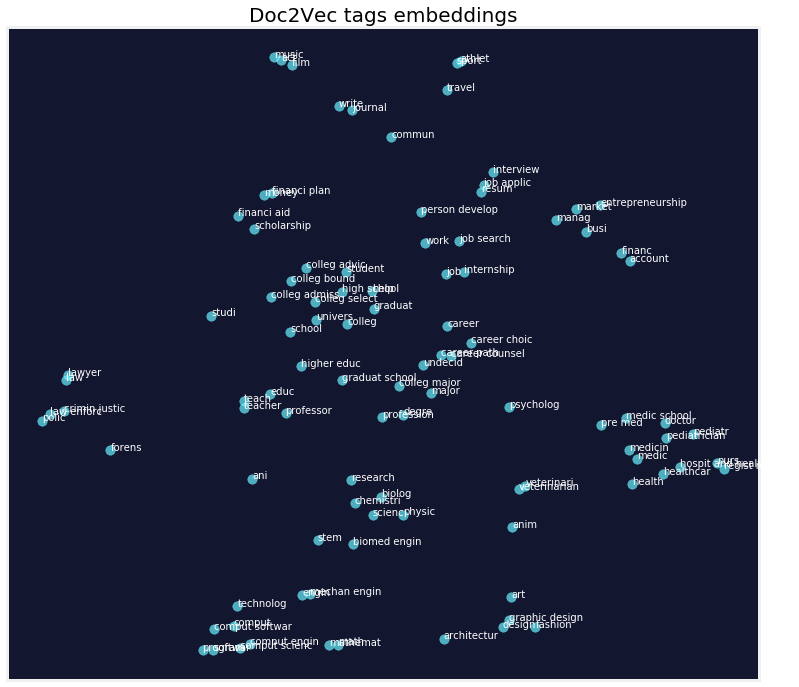

In [9]:
vis_emb(tag_embs, tag_que['tags_tag_name'], 'Doc2Vec tags embeddings')

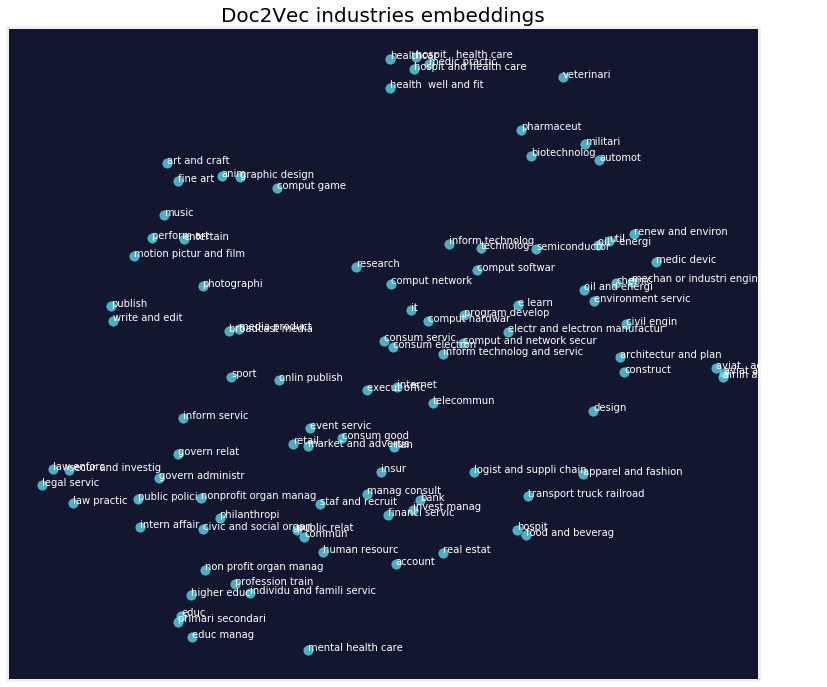

In [10]:
vis_emb(ind_embs, pro_train['professionals_industry'], 'Doc2Vec industries embeddings')

In [11]:
# construct dataframe used to extract positive pairs
pairs_df = questions.merge(answers, left_on='questions_id', right_on='answers_question_id') \
    .merge(professionals, left_on='answers_author_id', right_on='professionals_id') \
    .merge(students, left_on='questions_author_id', right_on='students_id')

pairs_df = pairs_df[['questions_id', 'students_id', 'professionals_id', 'answers_date_added']]

# extract positive pairs
pos_pairs = list(pairs_df.loc[pairs_df['answers_date_added'] < SPLIT_DATE].itertuples(index=False, name=None))

# extract professional answers for activity filters
pro_answers = pairs_df.drop(columns=['students_id']).set_index('professionals_id')

In [12]:
qa_data = questions.merge(answers, left_on='questions_id', right_on='answers_question_id')

In [13]:
from abc import ABC
from sklearn.preprocessing import StandardScaler, LabelEncoder

class BaseProc(ABC):
    """
    Class with implementation of basic preprocessors logic
    """

    def __init__(self):
        self.pp = {}
        self.features = {
            'categorical': [],
            'numerical': {'zero': [], 'mean': []},
            'date': []
        }

    def _unroll_features(self):
        """
        Called once after self.features specification in constructor of child class,
        unrolls all the features in single separate list self.features['all']
        """
        self.features['all'] = ([name for name, deg in self.features['categorical']]
                                if 'categorical' in self.features else []) + \
                               (self.features['numerical']['zero'] + self.features['numerical']['mean']
                                if 'numerical' in self.features else []) + \
                               ([f + p for f in self.features['date']
                                 for p in ['_time', '_doy_sin', '_doy_cos']]
                                if 'date' in self.features else [])

    def datetime(self, df: pd.DataFrame, feature: str):
        """
        Generates a bunch of new datetime features and drops the original feature inplace

        :param df: data to work with
        :param feature: name of a column in df that contains date
        """
        # iterate over suffix of generated features and function to calculate it
        for suf, fun in [('_time', lambda d: d.year + (d.dayofyear + d.hour / 24) / 365),
                         ('_doy_sin', lambda d: np.sin(2 * np.pi * d.dayofyear / 365)),
                         ('_doy_cos', lambda d: np.cos(2 * np.pi * d.dayofyear / 365))]:
            df[feature + suf] = df[feature].apply(fun)
            # add created feature to the list of generated features
            self.features['gen'].append(feature + suf)

        df.drop(columns=feature, inplace=True)

    def __get_preprocessor(self, fit_data: np.array, feature: str, base):
        """
        Creates new preprocessor object of class base and fits it
        or uses existing one in self.pp and returns it

        :param fit_data: NumPy array of data to fit new preprocessor
        :param feature: feature name to search for in self.pp
        :param base: new preprocessor's class
        :returns: preprocessor object
        """
        if feature in self.pp:
            preproc = self.pp[feature]
        else:
            preproc = base()
            preproc.fit(fit_data)
            self.pp[feature] = preproc
        return preproc

    def numerical(self, df: pd.DataFrame, feature: str, fillmode: str):
        """
        Transforms via StandardScaler, fills NaNs according to fillmode

        :param df: data to work with
        :param feature: name of a column in df that contains numerical data
        :param fillmode: method to fill NaNs, either 'mean' or 'zero'
        """
        # calculate default value and fill NaNs with it
        if fillmode == 'mean':
            if feature in self.pp:
                na = self.pp[feature].mean_[0]
            else:
                na = df[feature].mean()
        else:
            na = 0

        df[feature].fillna(na, inplace=True)

        # standardize feature values
        fit_data = df[feature].values.reshape(-1, 1).astype('float64')
        sc = self.__get_preprocessor(fit_data, feature, StandardScaler)
        df[feature] = sc.transform(fit_data)

    def categorical(self, df: pd.DataFrame, feature: str, n: int):
        """
        Encodes top n most popular values with different labels from 0 to n-1,
        remaining values with n and NaNs with n+1

        :param df: data to work with
        :param feature: name of a column in df that contains categorical data
        :param n: number of top by popularity values to move in separate categories.
                  0 to encode everything with different labels
        """
        vc = df[feature].value_counts()
        # number of unique values to leave
        n = len(vc) if n == 0 else n
        # unique values to leave
        top = set(vc[:n].index)
        isin_top = df[feature].isin(top)

        fit_data = df.loc[isin_top, feature]
        le = self.__get_preprocessor(fit_data, feature, LabelEncoder)

        # isin_le differs from isin_top if new preprocessor object was fitted
        isin_le = df[feature].isin(set(le.classes_))
        df.loc[isin_le, feature] = le.transform(df.loc[isin_le, feature])

        # unique values to throw away - encode with single label n
        bottom = set(vc.index) - set(le.classes_)
        isin_bottom = df[feature].isin(bottom)
        df.loc[isin_bottom, feature] = n

        df[feature].fillna(n + 1, inplace=True)

    def preprocess(self, df: pd.DataFrame):
        """
        Full preprocessing pipeline

        :param df: data to work with
        """
        # preprocess all date features
        self.features['gen'] = []
        if 'date' in self.features:
            for feature in self.features['date']:
                self.datetime(df, feature)

        # preprocess all numerical features, including generated features from dates
        if 'numerical' in self.features:
            for fillmode in self.features['numerical']:
                for feature in self.features['numerical'][fillmode] + \
                               (self.features['gen'] if fillmode == 'mean' else []):
                    if feature in df.columns:
                        self.numerical(df, feature, fillmode)

        # preprocess all categorical features
        if 'categorical' in self.features:
            for feature, n in self.features['categorical']:
                self.categorical(df, feature, n)

In [14]:
"""
#### Question's features processing class
- **Numerical**
    - Question's body length in symbols
    - Question's number of tags
- Averaged question's tags embeddings pre-trained via doc2vec
- Unique question's embedding inferred via doc2vec 
"""

class process_quest_features(BaseProc):
    """
    :que: question dataFrame with preprocessed dataset
    :tags: merged tags and tag_questions dataframes with preprocessed textual columns
    :return: dataframe of question's id, question's date added and model-friendly question's features
    """
    
    def __init__(self, tag_embs, ques_d2v):
        super().__init__()
        self.tag_embs = tag_embs
        self.ques_d2v = ques_d2v
        self.features = {
            'numerical': {
                'zero': ['questions_body_length', 'questions_tag_count'],
                'mean': []
            }
        }

        self._unroll_features()
    
    def transform(self, que, tags):
        que['questions_body_len'] = que['questions_body'].apply(lambda x:len(str(x)))
        # append aggregated tags to each question
        tags_grouped = tags.groupby('tag_questions_question_id', as_index=False)[['tags_tag_name']] \
            .agg(lambda x: ' '.join(set(x)))
        tags_grouped['questions_tag_count'] = tags_grouped['tags_tag_name'].apply(lambda x: len(x.split()))
        df = que.merge(tags_grouped, how='left', left_on='questions_id', right_on='tag_questions_question_id')
        # process dataframe
        self.preprocess(df)
        # prepare tag embeddings
        tag_emb_len = list(self.tag_embs.values())[0].shape[0]
        def __convert(x):
            avg_emb = []
            for tag in str(x).split():
                if tag in self.tag_embs:
                    avg_emb.append(self.tag_embs[tag])
            if len(avg_emb)==0: 
                avg_emb.append(np.zeros(tag_emb_len))
            return np.vstack(avg_emb).mean(axis=0)
        mean_embs = df['tags_tag_name'].apply(__convert)
        
        for i in range(tag_emb_len):
            df[f'que_tag_emb_{i}'] = mean_embs.apply(lambda x: x[i])
        
        # question embedding
        d2v_emb_len = len(self.ques_d2v.infer_vector([]))
        def __infer_d2v(s):
            self.ques_d2v.random.seed(0)
            return self.ques_d2v.infer_vector(s.split(), steps=100)

        d2v_que_embs = df['questions_whole'].apply(__infer_d2v)
        
        for i in range(d2v_emb_len):
            df[f'que_d2v_emb_{i}'] = d2v_que_embs.apply(lambda x: x[i])
        
        return df

In [15]:
quest_feat = process_quest_features(tag_embs, ques_d2v)
que_data_train = quest_feat.transform(que_train, tag_que)

In [16]:
display(students.head())
display(que_train.head())
display(answers.head())

,students_id,students_location,students_date_joined,date_last_question,date_first_question,date_last_comment,date_first_comment,date_last_activity,date_first_activity
0,12a89e96755a4dba83ff03e03043d9c0,NaN,2011-12-16 14:19:24,2011-12-16 14:26:31,2011-12-16 14:26:31,NaT,NaT,2011-12-16 14:26:31,2011-12-16 14:26:31
1,e37a5990fe354c60be5e87376b08d5e3,NaN,2011-12-27 03:02:44,NaT,NaT,NaT,NaT,NaT,NaT
2,12b402cceeda43dcb6e12ef9f2d221ea,NaN,2012-01-01 05:00:00,NaT,NaT,NaT,NaT,NaT,NaT
3,a0f431fc79794edcb104f68ce55ab897,NaN,2012-01-01 05:00:00,NaT,NaT,NaT,NaT,NaT,NaT
4,23aea4702d804bd88d1e9fb28074a1b4,NaN,2012-01-01 05:00:00,NaT,NaT,NaT,NaT,NaT,NaT


,questions_id,questions_author_id,questions_date_added,questions_title,questions_body,questions_whole,questions_body_len
0,332a511f1569444485cf7a7a556a5e54,8f6f374ffd834d258ab69d376dd998f5,2016-04-26 11:14:26,teacher career question,what is a math teacher what is a mat...,teacher career question what is a math ...,89
1,eb80205482e4424cad8f16bc25aa2d9c,acccbda28edd4362ab03fb8b6fd2d67b,2016-05-20 16:48:25,i want to becom an armi offic what can i do t...,i am priyanka from bangalor now am in th s...,i want to becom an armi offic what can i do t...,180
2,4ec31632938a40b98909416bdd0decff,f2c179a563024ccc927399ce529094b5,2017-02-08 19:13:38,will go abroad for your first job increas your...,i m plan on go abroad for my first job it wil...,will go abroad for your first job increas your...,429
3,2f6a9a99d9b24e5baa50d40d0ba50a75,2c30ffba444e40eabb4583b55233a5a4,2017-09-01 14:05:32,to becom a specialist in busi manag will i h...,i hear busi manag is a hard way to get a job i...,to becom a specialist in busi manag will i h...,99
4,5af8880460c141dbb02971a1a8369529,aa9eb1a2ab184ebbb00dc01ab663428a,2017-09-01 02:36:54,are there ani scholarship out there for studen...,i m tri to find scholarship for first year stu...,are there ani scholarship out there for studen...,173


,answers_id,answers_author_id,answers_question_id,answers_date_added,answers_body
0,4e5f01128cae4f6d8fd697cec5dca60c,36ff3b3666df400f956f8335cf53e09e,332a511f1569444485cf7a7a556a5e54,2016-04-29 19:40:14,hi you are ask a veri interest question ...
1,ada720538c014e9b8a6dceed09385ee3,2aa47af241bf42a4b874c453f0381bd4,eb80205482e4424cad8f16bc25aa2d9c,2018-05-01 14:19:08,hi i join the armi after i attend colleg and...
2,eaa66ef919bc408ab5296237440e323f,cbd8f30613a849bf918aed5c010340be,eb80205482e4424cad8f16bc25aa2d9c,2018-05-02 02:41:02,dear priyanka greet i have answer thi ques...
3,1a6b3749d391486c9e371fbd1e605014,7e72a630c303442ba92ff00e8ea451df,4ec31632938a40b98909416bdd0decff,2017-05-10 19:00:47,i work for a global compani who valu highli i...
4,5229c514000446d582050f89ebd4e184,17802d94699140b0a0d2995f30c034c6,2f6a9a99d9b24e5baa50d40d0ba50a75,2017-10-13 22:07:33,i agre with denis everi singl job i ve had si...


In [17]:
"""
Students Features Preprocessing Class
Categorical
    Location
    State - extracted from location
Numerical
    Number of asked questions
    Average asked question body length
    Average body length of answer on student's questions
    Average number of answers on student's questions
"""
class Averager:
    """
    Small class useful for computing averaged features values
    """
    
    def __init__(self):
        self.sum = 0
        self.cnt = 0

    def upd(self, val):
        self.sum += val
        self.cnt += 1

    def get(self):
        if self.cnt == 0:
            return None
        return self.sum / self.cnt
class StuProc(BaseProc):
    """
    Students data preprocessor
    """

    def __init__(self):
        super().__init__()

        self.features = {
            'categorical': [('students_location', 100), ('students_state', 40)],
            'numerical': {
                'zero': ['students_questions_asked'],
                'mean': ['students_average_question_body_length', 'students_average_answer_body_length',
                         'students_average_answer_amount']
            },
            'date': []
        }

        self._unroll_features()

    def transform(self, stu, que, ans) -> pd.DataFrame:
        """
        Main method to calculate, preprocess students's features and append textual embeddings

        :param stu: students dataframe with preprocessed textual columns
        :param que: questions dataframe with preprocessed textual columns
        :param ans: answers dataframe with preprocessed textual columns
        :return: dataframe of students's id, timestamp and model-friendly students's features after that timestamp
        """
        stu['students_state'] = stu['students_location'].apply(lambda s: str(s).split(', ')[-1])

        que['questions_body_length'] = que['questions_body'].apply(lambda s: len(str(s)))
        ans['answers_body_length'] = ans['answers_body'].apply(lambda s: len(str(s)))

        # prepare all the dataframes needed for iteration
        que_change = stu.merge(que, left_on='students_id', right_on='questions_author_id')
        ans_change = que_change.merge(ans, left_on='questions_id', right_on='answers_question_id') \
            .rename(columns={'answers_date_added': 'students_time'})

        # add new columns which will be used to determine to which change corressponds stacked DataFrame row
        ans_change['change_type'] = 'answer'
        que_change['change_type'] = 'question'
        que_change = que_change.rename(columns={'questions_date_added': 'students_time'})

        # stack two DataFrame to form resulting one for iteration
        df = pd.concat([que_change, ans_change], ignore_index=True, sort=True).sort_values('students_time')

        # data is a dist with mapping from student's id to his list of features
        # each list contains dicts with mapping from feature name to its value on a particular moment
        data = {}
        avgs = {}

        for i, row in stu.iterrows():
            cur_stu = row['students_id']
            
            # DEFAULT CASE
            # student's feature values before he left any questions
            if cur_stu not in data:
                new = {'students_questions_asked': 0,
                       'students_previous_question_time': row['students_date_joined']}
                for feature in ['students_time'] + self.features['numerical']['mean']:
                    new[feature] = None
                data[cur_stu] = [new]
                avgs[cur_stu] = {feature: Averager() for feature in self.features['numerical']['mean']}
        
        for i, row in df.iterrows():
            cur_stu = row['students_id']

            # features on previous timestamp
            prv = data[cur_stu][-1]
            new = prv.copy()

            new['students_time'] = row['students_time']

            # UPDATE RULES
            # if current change is new question, update question-depended features
            if row['change_type'] == 'question':
                new['students_questions_asked'] += 1
                new['students_previous_question_time'] = row['questions_date_added']
                new['students_average_question_body_length'] = row['questions_body_length']
            # if new answer is added, update answer-depended features
            else:  
                new['students_average_answer_body_length'] = row['answers_body_length']
                new['students_average_answer_amount'] = new['students_average_answer_amount'] + 1 \
                    if new['students_average_answer_amount'] is not None else 1

            # NORMALIZE AVERAGE FEATURES
            for feature in ['students_average_question_body_length'] if row['change_type'] == 'question' else \
                    ['students_average_answer_body_length', 'students_average_answer_amount']:
                avgs[cur_stu][feature].upd(new[feature])
                new[feature] = avgs[cur_stu][feature].get()

            data[cur_stu].append(new)

        # construct a DataFrame out of dict of list of feature dicts
        df = pd.DataFrame([{**f, **{'students_id': id}} for (id, fs) in data.items() for f in fs])

        df = df.merge(stu, on='students_id')
        # launch feature pre-processing
        self.preprocess(df)

        # re-order the columns
        df = df[['students_id', 'students_time'] + self.features['all']]

        return df

In [18]:
stu_proc = StuProc()
stu_data = stu_proc.transform(stu_train, que_train, ans_train)

In [19]:
class QueProc(BaseProc):
    """
    Questions data preprocessor
    """

    def __init__(self, tag_embs, ques_d2v):
        super().__init__()

        self.tag_embs = tag_embs
        self.ques_d2v = ques_d2v

        self.features = {
            'numerical': {
                'zero': ['questions_body_length', 'questions_tag_count'],
                'mean': []
            }
        }

        self._unroll_features()

    def transform(self, que, tags):
        """
        Main method to calculate, preprocess question's features and append textual embeddings

        :param que: questions dataframe with preprocessed textual columns
        :param tags: merged tags and tag_questions dataframes with preprocessed textual columns
        :return: dataframe of question's id, question's date added and model-friendly question's features
        """
        que['questions_time'] = que['questions_date_added']
        que['questions_body_length'] = que['questions_body'].apply(lambda s: len(str(s)))

        # append aggregated tags to each question
        tags_grouped = tags.groupby('tag_questions_question_id', as_index=False)[['tags_tag_name']] \
            .agg(lambda x: ' '.join(set(x)))
        tags_grouped['questions_tag_count'] = tags_grouped['tags_tag_name'].apply(lambda x: len(x.split()))
        df = que.merge(tags_grouped, how='left', left_on='questions_id', right_on='tag_questions_question_id')

        # launch feature pre-processing
        self.preprocess(df)

        # prepare tag embeddings

        tag_emb_len = list(self.tag_embs.values())[0].shape[0]

        def __convert(s):
            embs = []
            for tag in str(s).split():
                if tag in self.tag_embs:
                    embs.append(self.tag_embs[tag])
            if len(embs) == 0:
                embs.append(np.zeros(tag_emb_len))
            return np.vstack(embs).mean(axis=0)

        mean_embs = df['tags_tag_name'].apply(__convert)

        d2v_emb_len = len(self.ques_d2v.infer_vector([]))

        def __infer_d2v(s):
            self.ques_d2v.random.seed(0)
            return self.ques_d2v.infer_vector(s.split(), steps=100)

        d2v_que_embs = df['questions_whole'].apply(__infer_d2v)

        # re-order the columns
        df = df[['questions_id', 'questions_time'] + self.features['all']]

        # append d2v question embeddings
        for i in range(d2v_emb_len):
            df[f'que_d2v_emb_{i}'] = d2v_que_embs.apply(lambda x: x[i])
        # append tag embeddings
        for i in range(tag_emb_len):
            df[f'que_tag_emb_{i}'] = mean_embs.apply(lambda x: x[i])

        return df



que_proc = QueProc(tag_embs, ques_d2v)
que_data = que_proc.transform(que_train, tag_que)

In [50]:
"""
Professionals Features Preprocessing Class
Categorical
    Industry
    Location
    State - extracted from location
Numerical
    Average answered question's body length
    Average answer's body length
    Averaged subscribed tag embedding pre-trained via doc2vec
    Industry embedding pre-trained via doc2vec
    Headline embedding infered via doc2vec
    Averaged question embedding infered via doc2vec
"""

class ProProc(BaseProc):
    """
    Professionals data preprocessor
    """

    def __init__(self, tag_embs, ind_embs, head_d2v, ques_d2v):
        super().__init__()

        self.tag_embs = tag_embs
        self.ind_embs = ind_embs

        self.head_d2v = head_d2v
        self.ques_d2v = ques_d2v

        self.features = {
            'categorical': [('professionals_industry', 100), ('professionals_location', 100),
                            ('professionals_state', 40)],
            'numerical': {
                'zero': [],  # ['professionals_questions_answered'],
                'mean': ['professionals_average_question_body_length',
                         'professionals_average_answer_body_length']
            }
        }

        self._unroll_features()


    def transform(self, pro, que, ans, tags) -> pd.DataFrame:
        """
        Main method to calculate, preprocess students's features and append textual embeddings

        :param pro: professionals dataframe with preprocessed textual columns
        :param que: questions dataframe with preprocessed textual columns
        :param ans: answers dataframe with preprocessed textual columns
        :param tags: merged tags and tag_users dataframes with preprocessed textual columns
        :return: dataframe of professional's id, timestamp and model-friendly professional's features after that timestamp
        """
        # aggregate tags for each professional
        tags_grouped = tags.groupby('tag_users_user_id', as_index=False)[['tags_tag_name']] \
            .aggregate(lambda x: ' '.join(set(x)))

        pro['professionals_industry_raw'] = pro['professionals_industry']
        pro['professionals_state'] = pro['professionals_location'].apply(lambda loc: str(loc).split(', ')[-1])
        que['questions_body_length'] = que['questions_body'].apply(lambda s: len(str(s)))
        ans['answers_body_length'] = ans['answers_body'].apply(lambda s: len(str(s)))

        # prepare all the dataframes needed for iteration
        df = pro.merge(ans, left_on='professionals_id', right_on='answers_author_id') \
            .merge(que, left_on='answers_question_id', right_on='questions_id') \
            .sort_values('answers_date_added')

        # data is a dist with mapping from professional's id to his list of features
        # each list contains dicts with mapping from feature name to its value on a particular moment
        data = {}
        que_emb_len = len(self.ques_d2v.infer_vector([]))

        for i, row in pro.iterrows():
            cur_pro = row['professionals_id']

            # DEFAULT CASE
            # professional's feature values before he left any questions
            if cur_pro not in data:
                new = {'professionals_questions_answered': 0,
                       'professionals_previous_answer_date': row['professionals_date_joined']}
                for feature in ['professionals_time', 'professionals_average_question_age',
                                'professionals_average_question_body_length',
                                'professionals_average_answer_body_length']:
                    new[feature] = None
                new['pro_que_emb'] = np.zeros(que_emb_len)
                data[cur_pro] = [new]

        def __infer_d2v(s):
            self.ques_d2v.random.seed(0)
            return self.ques_d2v.infer_vector(s.split(), steps=100)

        for i, row in df.iterrows():
            cur_pro = row['professionals_id']

            prv = data[cur_pro][-1]
            # UPDATE RULES
            new = {'professionals_time': row['answers_date_added'],
                   'professionals_questions_answered': prv['professionals_questions_answered'] + 1,
                   'professionals_previous_answer_date': row['answers_date_added'],
                   'professionals_average_question_age':
                       (row['answers_date_added'] - row['questions_date_added']) / np.timedelta64(1, 's'),
                   'professionals_average_question_body_length': row['questions_body_length'],
                   'professionals_average_answer_body_length': row['answers_body_length'],
                   'pro_que_emb': __infer_d2v(row['questions_whole'])}
            length = len(data[cur_pro])
            if length != 1:
                # NORMALIZE AVERAGE FEATURES
                for feature in ['professionals_average_question_age', 'professionals_average_question_body_length',
                                'professionals_average_answer_body_length', 'pro_que_emb']:
                    new[feature] = (prv[feature] * (length - 1) + new[feature]) / length
            data[cur_pro].append(new)

        # construct a dataframe out of dict of list of feature dicts
        df = pd.DataFrame([{**f, **{'professionals_id': id}} for (id, fs) in data.items() for f in fs])

        df = df.merge(pro, on='professionals_id').merge(tags_grouped, how='left', left_on='professionals_id',
                                                        right_on='tag_users_user_id')
        # launch feature pre-processing
        self.preprocess(df)

        # prepare subscribed tag embeddings

        tag_emb_len = list(self.tag_embs.values())[0].shape[0]

        def __convert_tag(s):
            embs = []
            for tag in str(s).split():
                if tag in self.tag_embs:
                    embs.append(self.tag_embs[tag])
            if len(embs) == 0:
                embs.append(np.zeros(tag_emb_len))
            return np.vstack(embs).mean(axis=0)

        mean_tag_embs = df['tags_tag_name'].apply(__convert_tag)

        # prepare industry embeddings
        industry_emb_len = list(self.ind_embs.values())[0].shape[0]
        ind_embs = df['professionals_industry_raw'] \
            .apply(lambda x: self.ind_embs.get(x, np.zeros(industry_emb_len)))

        head_emb_len = len(self.head_d2v.infer_vector([]))

        def __convert_headline(s):
            self.head_d2v.random.seed(0)
            return self.head_d2v.infer_vector(s.split(), steps=100)

        head_embs = df['professionals_headline'].apply(__convert_headline)

        que_embs = df['pro_que_emb']

        # re-order the columns
        df = df[['professionals_id', 'professionals_time'] + self.features['all']]

        # append subscribed tag embeddings
        for i in range(tag_emb_len):
            df[f'pro_tag_emb_{i}'] = mean_tag_embs.apply(lambda x: x[i])

        for i in range(industry_emb_len):
            df[f'pro_ind_emb_{i}'] = ind_embs.apply(lambda x: x[i])

        for i in range(head_emb_len):
            df[f'pro_head_emb_{i}'] = head_embs.apply(lambda x: x[i])

        for i in range(que_emb_len):
            df[f'pro_que_emb_{i}'] = que_embs.apply(lambda x: x[i])

        return df
pro_proc = ProProc(tag_embs, ind_embs, head_d2v, ques_d2v)
pro_data = pro_proc.transform(pro_train, que_train, ans_train, tag_pro)

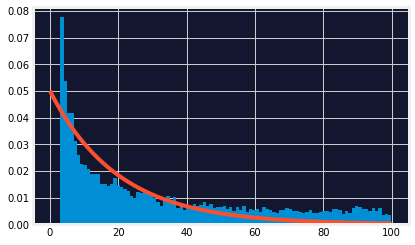

In [21]:
qa_data['duration_to_answer'] =  pd.to_datetime(qa_data['answers_date_added']) - pd.to_datetime(qa_data['questions_date_added'])
# qa_data['duration_to_answer'].dt.seconds.plot(kind='hist', figsize=(15,10), bins=200, density=True)
que_age = qa_data['duration_to_answer'].apply(lambda x: x.days + np.round(x.seconds / 3600) / 24)
cut_que_age = que_age[(que_age < 100) & (que_age > 3)]
cut_que_age.hist(bins=100, density=True)

lambd = 1 / 20

# Plot exponential distribution
x = np.linspace(0, 100, 1000)
y = lambd * np.exp(-lambd * x)

plt.plot(x, y)
plt.show()

In [26]:
# construct dataframe used to extract positive pairs
pairs_df = questions.merge(answers, left_on='questions_id', right_on='answers_question_id') \
    .merge(professionals, left_on='answers_author_id', right_on='professionals_id') \
    .merge(students, left_on='questions_author_id', right_on='students_id')

pairs_df = pairs_df[['questions_id', 'students_id', 'professionals_id', 'answers_date_added']]

# extract positive pairs
pos_pairs = list(pairs_df.loc[pairs_df['answers_date_added'] < SPLIT_DATE].itertuples(index=False, name=None))

# extract professional answers for activity filters
pro_answers = pairs_df.drop(columns=['students_id']).set_index('professionals_id')

In [48]:
class BatchGenerator(keras.utils.Sequence):
    """
    Class to ingest data from pre-processed DataFrames to model
    in form of batches of NumPy arrays
    """
    
    exp_mean = 30
    
    def __init__(self, que: pd.DataFrame, stu: pd.DataFrame, pro: pd.DataFrame,
                 batch_size: int, pos_pairs: list, nonneg_pairs: list, pro_dates: dict):
        """
        :param que: pre-processed questions data
        :param stu: pre-processed students data
        :param pro: pre-processed professionals data
        :param batch_size: actually, half of the real batch size
        Number of both positive and negative pairs present in generated batch
        :param pos_pairs: tuples of question, student and professional, which form positive pair
        (professional answered on the given question from corresponding student)
        :param nonneg_pairs: tuples of question, student and professional, which are known to form a positive pair.
        Superset of pos_pairs, used in sampling of negative pairs
        :param pro_dates: mappings from professional's id to his registration date
        """
        self.batch_size = batch_size

        # extract mappings from question's id to question's date and features
        que_ar = que.values
        self.que_feat = {que_ar[i, 0]: que_ar[i, 2:] for i in range(que_ar.shape[0])}
        self.que_time = {que_ar[i, 0]: pd.Timestamp(que_ar[i, 1]) for i in range(que_ar.shape[0])}

        self.pos_pairs = pos_pairs
        self.on_epoch_end()  # shuffle pos_pairs
        self.nonneg_pairs = {(que, stu, pro) for que, stu, pro, time in nonneg_pairs}

        # these lists are used in sampling of negative pairs
        self.ques_stus_times = [(que, stu, self.que_time[que]) for que, stu, pro, time in pos_pairs]

        self.pros = np.array([pro for que, stu, pro, time in nonneg_pairs])
        self.pros_times = np.array([pro_dates[pro] for que, stu, pro, time in nonneg_pairs])

        # simultaneously sort two arrays containing professional features
        sorted_args = np.argsort(self.pros_times)
        self.pros = self.pros[sorted_args]
        self.pros_times = self.pros_times[sorted_args]

        # extract mappings from student's id to student's date and features
        self.stu_feat = {}
        self.stu_time = {}
        for stu_id, group in stu.groupby('students_id'):
            group_ar = group.values[:, 1:]
            self.stu_feat[stu_id] = np.array([group_ar[i, 1:] for i in range(group_ar.shape[0])])
            self.stu_time[stu_id] = np.array([group_ar[i, 0] for i in range(group_ar.shape[0])])

        # extract mappings from professional's id to professional's date and features
        self.pro_feat = {}
        self.pro_time = {}
        for pro_id, group in pro.groupby('professionals_id'):
            group_ar = group.values[:, 1:]
            self.pro_feat[pro_id] = np.array([group_ar[i, 1:] for i in range(group_ar.shape[0])])
            self.pro_time[pro_id] = np.array([group_ar[i, 0] for i in range(group_ar.shape[0])])

    def __len__(self):
        return len(self.pos_pairs) // self.batch_size

    @staticmethod
    def __find(feat_ar: np.ndarray, time_ar: np.ndarray, search_time):
        pos = np.searchsorted(time_ar[1:], search_time)
        assert time_ar[pos] is pd.NaT or time_ar[pos] < search_time
        return feat_ar[pos]

    def __convert(self, pairs: list) -> (np.ndarray, np.ndarray):
        """
        Convert list of pairs of ids to NumPy arrays
        of question and professionals features
        """
        x_que, x_pro, current_times = [], [], []
        for que, stu, pro, current_time in pairs:
            que_data = self.que_feat[que]

            # find student's and professional's feature at current time
            stu_data = BatchGenerator.__find(self.stu_feat[stu], self.stu_time[stu], current_time)
            pro_data = BatchGenerator.__find(self.pro_feat[pro], self.pro_time[pro], current_time)

            # prepare current time as feature itself
            current_time = current_time.year + (current_time.dayofyear + current_time.hour / 24) / 365
            current_times.append(current_time)

            x_que.append(np.hstack([stu_data, que_data]))
            x_pro.append(pro_data)

        # and append them to both questions and professionals
        return np.vstack(x_que), np.vstack(x_pro)

    def __getitem__(self, index):
        """
        Generate the batch
        """
        pos_pairs = self.pos_pairs[self.batch_size * index: self.batch_size * (index + 1)]
        neg_pairs = []

        for i in range(len(pos_pairs)):
            while True:
                # sample question, its student and time
                que, stu, zero = random.choice(self.ques_stus_times)
                # calculate shift between question's and current time
                shift = np.random.exponential(BatchGenerator.exp_mean)
                current_time = zero + pd.Timedelta(int(shift * 24 * 60), 'm')
                # find number of professionals with registration date before current time
                i = np.searchsorted(self.pros_times, current_time)
                if i != 0:
                    break

            while True:
                # sample professional for negative pair
                pro = random.choice(self.pros[:i])
                # check if he doesn't form a positive pair
                if (que, stu, pro) not in self.nonneg_pairs:
                    neg_pairs.append((que, stu, pro, current_time))
                    break

        # convert lists of pairs to NumPy arrays of features
        x_pos_que, x_pos_pro = self.__convert(pos_pairs)
        x_neg_que, x_neg_pro = self.__convert(neg_pairs)

        # return the data in its final form
        return [np.vstack([x_pos_que, x_neg_que]), np.vstack([x_pos_pro, x_neg_pro])], \
               np.vstack([np.ones((len(x_pos_que), 1)), np.zeros((len(x_neg_que), 1))])

    def on_epoch_end(self):
        # shuffle positive pairs
        self.pos_pairs = random.sample(self.pos_pairs, len(self.pos_pairs))
        
# mappings from professional's id to his registration date. Used in batch generator
pro_to_date = {row['professionals_id']: row['professionals_date_joined'] for i, row in professionals.iterrows()}

In [51]:
bg = BatchGenerator(que_data, stu_data, pro_data, 64, pos_pairs, pos_pairs, pro_to_date)

In [154]:
from keras.models import Model
from keras.layers import Input, Dense, Concatenate, Lambda, Embedding
from keras.optimizers import Adam

def categorize(inputs, emb_input_dims, emb_output_dims):
    """
    Replaces categorical features with trainable embeddings
    :param inputs: tensor with encoded categorical features in first columns
    :param emb_input_dims: number of unique classes in categorical features
    :param emb_output_dims: embedding dimensions of categorical features
    :return: transformed tensor
    """
    n_embs = len(emb_input_dims)
    if n_embs > 0:
        embs = []

        # iterate over categorical features
        for i, nunique, dim in zip(range(n_embs), emb_input_dims, emb_output_dims):
            print(i,nunique, dim)
            # separate their values with Lambda layer
            tmp = Lambda(lambda x: x[:, i])(inputs)
            # pass them through Embedding layer
            embs.append(Embedding(nunique, dim)(tmp))

        # pass all the numerical features directly
        embs.append(Lambda(lambda x: x[:, n_embs:])(inputs))
        # and concatenate them
        outputs = Concatenate()(embs)
    else:
        outputs = inputs

    return outputs

class Model(Model):
    def __init__(self, que_dim, prof_dim, 
                 que_input_embs, que_outp_embs,
                 prof_input_embs, prof_outp_embs,
                 dense1_dim, dense2_dim
                ):
        
        super().__init__()
        
        self.que_feats = Input((que_dim,))
        self.prof_feats = Input((prof_dim,))
        
        self.que_catecorized= categorize(self.que_feats, que_input_embs, que_outp_embs)
        self.prof_catecorized= categorize(self.prof_feats, prof_input_embs, prof_outp_embs)
        
        self.merged = Concatenate()([self.que_catecorized, self.prof_catecorized])
#         self.merged = Concatenate()([self.que_feats, self.prof_feats])
        self.dense1 = Dense(dense1_dim, activation='tanh')(self.merged)
        self.dense2 = Dense(dense2_dim, activation='tanh')(self.dense1)
        self.outputs = Dense(1, activation='sigmoid')(self.dense2)

        super().__init__([self.que_feats, self.prof_feats], self.outputs)

In [155]:
model = Model(que_dim=len(que_data.columns) - 2 + len(stu_data.columns) - 2, 
              prof_dim=len(pro_data.columns) - 2,
              que_input_embs=[102, 42], que_outp_embs=[3, 3],
              prof_input_embs=[102,102, 42], prof_outp_embs=[3, 3],
              dense1_dim=15, dense2_dim=10)

2
0 102 3
1 42 3
3
0 102 3
1 102 3


In [152]:
model.summary()

Model: "model_39"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_55 (InputLayer)           (None, 28)           0                                            
__________________________________________________________________________________________________
input_56 (InputLayer)           (None, 40)           0                                            
__________________________________________________________________________________________________
lambda_140 (Lambda)             (None,)              0           input_55[0][0]                   
__________________________________________________________________________________________________
lambda_141 (Lambda)             (None,)              0           input_55[0][0]                   
___________________________________________________________________________________________

In [153]:
for lr, epochs in zip([0.01, 0.001, 0.0001, 0.00001], [5, 10, 10, 5]):
    model.compile(Adam(lr=lr), loss='binary_crossentropy', metrics=['accuracy'])
    model.fit_generator(bg, epochs=epochs, verbose=2)

Epoch 1/5
 - 6s - loss: 0.5531 - accuracy: 0.7133
Epoch 2/5
 - 6s - loss: 0.5114 - accuracy: 0.7477
Epoch 3/5


KeyboardInterrupt: 